## multiDGD - gene2peak perturbation example

In [ ]:
import os
import numpy as np
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiDGD

# make sure we are in the correct directory
def switch_to_project_dir(name):
    cwd = os.getcwd()
    dir_hierarchy = cwd.split('/')
    index = dir_hierarchy.index(name)
    if index != len(dir_hierarchy) - 1:
        os.chdir('/'.join(dir_hierarchy[:index+1]))
        print('Moved to project directory: ', os.getcwd())

switch_to_project_dir('multiDGD')

Moved to project directory:  /Users/vschuste/Documents/work_KU/projects/multiDGD


## Load a pre-trained model

See [example_adata_bonemarrow](https://github.com/Center-for-Health-Data-Science/multiDGD/blob/main/tutorials/example_adata_bonemarrow.ipynb) or [example_mapping_new_data](https://github.com/Center-for-Health-Data-Science/multiDGD/blob/main/tutorials/example_mapping_new_data.ipynb) tutorials for how to get a pretrained model.

In [7]:
# Load data
data = ad.read_h5ad('./data/human_bonemarrow.h5ad')

# load model from the saved checkpoint
# (has to be trained on test data)
model = multiDGD.DGD.load(data=data, save_dir='./models/', model_name='dgd_human_bonemarrow')

Covariate model initialized as:

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
#######################
Training status
#######################
True


## Gene2Peak

This feature performs in silico perturbations on the specified gene and predicts the changes in prediction on all output features.

Currently, we only support this being performed on the test data. See the tutorial on training and testing an anndata object for details on the model and test data.

Right now the perturbations only consist of silencing of the given gene. Thus, a negative predicted change suggests a positive correlation.

In [21]:
# in order to find the peak closest to the gene, we first need the gene coordinates for all peaks

coordinates = data.var[data.var['feature_types'] == 'ATAC'].index
chromosome_ids = [x.split('-')[0] for x in coordinates] # in this case items are separated by '-', make sure to check your data yourself
start_positions = [int(x.split('-')[1]) for x in coordinates]
end_positions = [int(x.split('-')[2]) for x in coordinates]

ref_df = pd.DataFrame({'Chromosome': chromosome_ids, 'Start': start_positions, 'End': end_positions, 'idx': np.arange(len(coordinates))})
print(ref_df.head())

  Chromosome   Start     End  idx
0       chr1    9776   10668    0
1       chr1  180726  181005    1
2       chr1  181117  181803    2
3       chr1  191133  192055    3
4       chr1  267562  268456    4


In [ ]:
from multiDGD.functions._gene2peak import get_closest_peak

# specify the gene we want to look at
gene_name = "ID2"
gene_location = "chr2:8678845-8684461"

chromosome = gene_location.split(":")[0]
start = gene_location.split(":")[1].split("-")[0]
end = gene_location.split(":")[1].split("-")[1]
peak_id = get_closest_peak(chromosome, start, end, ref_df)
print("Closest peaks to gene location: ", peak_id)

# and the samples we want to look at
test_set = data[data.obs["train_val_test"] == "test",:].copy()

Closest peaks to gene location:  [57601, 57602, 57603]


In [26]:
predicted_changes, samples_of_interest = model.gene2peak(gene_name=gene_name, testset=test_set)

using 1938 samples


In [27]:
delta_gex = predicted_changes[0]
delta_atac = predicted_changes[1]

### Visualize the changes

In [78]:
def plot_gel(testset, heatmap, gene_name, gene_loc, modality_switch, start_peak, end_peak, peak_id, cell_types):
    df_heatmap_1 = pd.DataFrame(
        heatmap.numpy(),
        columns=testset.var.index[
            modality_switch + start_peak : modality_switch + end_peak
        ],
        index=cell_types,
    )
    df_heatmap_1 = df_heatmap_1.sort_index()

    fig, ax = plt.subplots(figsize=(20, 5))
    sns.heatmap(df_heatmap_1, linewidth=0.0, cmap="RdBu_r", center=0)
    # annotate the peak id
    plt.annotate(
        "*",
        xy=(peak_id - start_peak, 0),
        xytext=(peak_id - start_peak, -1),
        ha="center",
        va="bottom",
        color="black",
        fontsize=14,
    )
    # set the title higher up
    plt.title(
        "prediction differences of peaks from {} gene silencing ({})".format(
            gene_name, gene_loc
        ),
        y=1.1,
    )
    plt.show()

    return df_heatmap_1

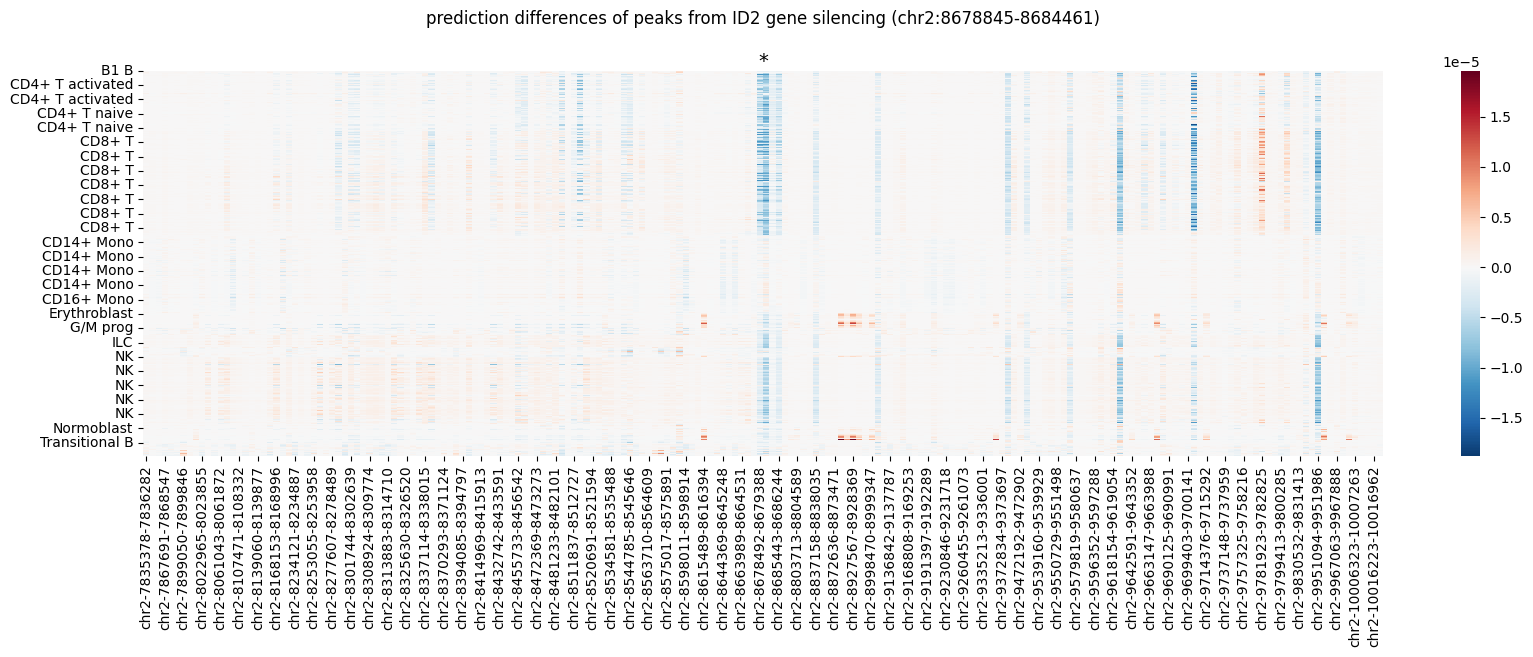

In [ ]:
peak_id = 57602 # and the one before and after, but not too relevant for plotting
start_peak = peak_id - 100
end_peak = peak_id + 100
modality_switch = delta_gex.shape[1]

cell_types = test_set.obs['cell_type'].values[samples_of_interest]
heatmap_1 = delta_atac[:,start_peak:end_peak]

# the asterisk indicates the peak closest to the gene
df_heatmap_1 = plot_gel(test_set, heatmap_1, gene_name, gene_location, modality_switch, start_peak, end_peak, peak_id, cell_types)